In [4]:
!pip install xgboost --quiet

In [5]:
# XGBoost Model Training for Transaction Volume Forecasting
# Tree-based model using engineered features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from google.cloud import storage
import pickle

# Configuration
PROJECT_ID = "transaction-forecast-mlops"
BUCKET_NAME = "transaction-forecast-data"

print("="*60)
print("XGBOOST MODEL TRAINING")
print("="*60)

# Load enriched data
print("\nLoading enriched dataset...")
df = pd.read_csv(f'gs://{BUCKET_NAME}/processed_data/daily_volumes_enriched.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"✓ Loaded {len(df)} days with {len(df.columns)} features")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFeatures available: {len(df.columns) - 2} (excluding date and target)")

XGBOOST MODEL TRAINING

Loading enriched dataset...
✓ Loaded 610 days with 28 features
Date range: 2016-09-04 00:00:00 to 2018-08-22 00:00:00

Features available: 26 (excluding date and target)


In [6]:
# Prepare features for XGBoost
print("\nPreparing features...")

# Features to exclude (non-predictive or target)
exclude_cols = ['date', 'transaction_volume', 'day_name']  # day_name is text

# Select numeric features only
feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols]
y = df['transaction_volume']

print(f"✓ Selected {len(feature_cols)} features")
print(f"Features: {feature_cols}")

# Split into train/test (last 14 days as test)
train_size = len(df) - 14
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Keep test dates for later comparison
test_dates = df['date'][train_size:].reset_index(drop=True)

print(f"\n✓ Train/test split:")
print(f"  Training: {len(X_train)} days")
print(f"  Testing:  {len(X_test)} days")
print(f"  Test period: {test_dates.min()} to {test_dates.max()}")


Preparing features...
✓ Selected 25 features
Features: ['day_of_week', 'month', 'quarter', 'day_of_month', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end', 'lag_1', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30', 'rolling_std_7', 'rolling_std_30', 'rolling_min_7', 'rolling_max_7', 'is_holiday', 'days_to_holiday', 'days_from_holiday', 'days_since_start', 'transaction_growth', 'momentum_7']

✓ Train/test split:
  Training: 596 days
  Testing:  14 days
  Test period: 2018-08-09 00:00:00 to 2018-08-22 00:00:00


In [9]:
# Train XGBoost model
print("\nTraining XGBoost model...")

# Create and configure XGBoost regressor
model = xgb.XGBRegressor(
    n_estimators=200,           # Number of trees
    max_depth=6,                 # How deep each tree can go
    learning_rate=0.1,           # Step size for updates
    objective='reg:squarederror', # Loss function for regression
    random_state=42              # For reproducibility
)

# Train the model
model.fit(X_train, y_train)

print("✓ Model trained successfully!")
print(f"\nModel configuration:")
print(f"  Trees: {model.n_estimators}")
print(f"  Max depth: {model.max_depth}")
print(f"  Learning rate: {model.learning_rate}")


Training XGBoost model...
✓ Model trained successfully!

Model configuration:
  Trees: 200
  Max depth: 6
  Learning rate: 0.1


In [10]:
# Make predictions on test set
print("\nGenerating predictions...")
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Create comparison dataframe
results = pd.DataFrame({
    'date': test_dates,
    'actual': y_test.values,
    'predicted': y_pred
})
results['error'] = results['actual'] - results['predicted']
results['abs_error'] = abs(results['error'])

print("✓ Predictions generated\n")
print("="*60)
print("XGBOOST MODEL PERFORMANCE")
print("="*60)
print(f"MAE (Mean Absolute Error):       {mae:.2f} transactions/day")
print(f"RMSE (Root Mean Squared Error):  {rmse:.2f} transactions/day")
print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")

print(f"\n{'='*60}")
print("PREDICTIONS VS ACTUALS")
print(f"{'='*60}")
print(results)

if mape < 15:
    print(f"\n✅ EXCELLENT: MAPE < 15%")
elif mape < 25:
    print(f"\n⚠️  GOOD: MAPE < 25%")
else:
    print(f"\n❌ NEEDS TUNING: MAPE > 25%")


Generating predictions...
✓ Predictions generated

XGBOOST MODEL PERFORMANCE
MAE (Mean Absolute Error):       15.14 transactions/day
RMSE (Root Mean Squared Error):  18.99 transactions/day
MAPE (Mean Absolute % Error):    6.41%

PREDICTIONS VS ACTUALS
         date  actual   predicted      error  abs_error
0  2018-08-09     289  280.202454   8.797546   8.797546
1  2018-08-10     256  252.200897   3.799103   3.799103
2  2018-08-11     188  196.522461  -8.522461   8.522461
3  2018-08-12     197  218.779495 -21.779495  21.779495
4  2018-08-13     292  329.125183 -37.125183  37.125183
5  2018-08-14     316  289.334808  26.665192  26.665192
6  2018-08-15     288  273.561066  14.438934  14.438934
7  2018-08-16     320  317.388214   2.611786   2.611786
8  2018-08-17     257  246.645309  10.354691  10.354691
9  2018-08-18     198  203.346466  -5.346466   5.346466
10 2018-08-19     204  224.217163 -20.217163  20.217163
11 2018-08-20     256  257.490417  -1.490417   1.490417
12 2018-08-21     2


FEATURE IMPORTANCE

Top 15 Most Important Features:
           feature  importance
     rolling_max_7    0.479934
    rolling_mean_7    0.167546
     rolling_min_7    0.139723
        momentum_7    0.079556
             lag_1    0.060006
     rolling_std_7    0.022561
       day_of_week    0.017403
transaction_growth    0.011260
             lag_7    0.008997
        is_holiday    0.004191
   rolling_mean_14    0.002982
      day_of_month    0.001350
  days_since_start    0.001200
   rolling_mean_30    0.001103
            lag_14    0.000627


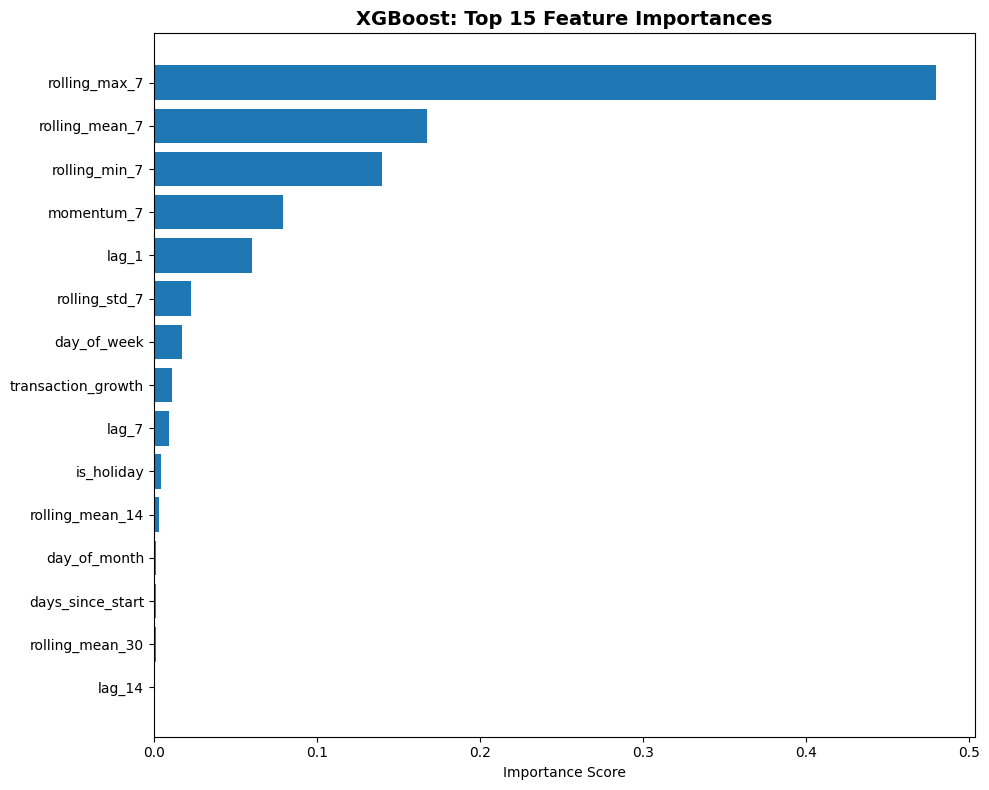


✓ Feature importance analysis complete
Most important feature: rolling_max_7 (0.4799)


In [11]:
# Feature importance analysis
print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)

# Get feature importances
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Show top 15 features
print("\nTop 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('XGBoost: Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis complete")
print(f"Most important feature: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.4f})")

In [12]:
# Save XGBoost model
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

# Save locally first
model_path = '/tmp/xgboost_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# Save feature list (needed for inference)
features_path = '/tmp/feature_cols.pkl'
with open(features_path, 'wb') as f:
    pickle.dump(feature_cols, f)

# Upload to GCS
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

blob = bucket.blob('models/xgboost_model.pkl')
blob.upload_from_filename(model_path)

blob = bucket.blob('models/xgboost_features.pkl')
blob.upload_from_filename(features_path)

print(f"✓ Model saved to gs://{BUCKET_NAME}/models/xgboost_model.pkl")
print(f"✓ Features saved to gs://{BUCKET_NAME}/models/xgboost_features.pkl")

print(f"\n{'='*60}")
print("XGBOOST TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Performance: {mape:.2f}% MAPE (vs Prophet: 9.89%)")
print(f"Improvement: {((9.89 - mape) / 9.89 * 100):.1f}% better than Prophet")


SAVING MODEL
✓ Model saved to gs://transaction-forecast-data/models/xgboost_model.pkl
✓ Features saved to gs://transaction-forecast-data/models/xgboost_features.pkl

XGBOOST TRAINING COMPLETE
Performance: 6.41% MAPE (vs Prophet: 9.89%)
Improvement: 35.2% better than Prophet
